In [2]:
from pyoculus.problems import AnalyticCylindricalBfield
from pyoculus.solvers import FixedPoint, Manifold
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.style.use('lateky')
import numpy as np
from pathlib import Path
import os

In [3]:
### Creating the pyoculus problem object
print("\nCreating the pyoculus problem object\n")

separatrix = {"type": "circular-current-loop", "amplitude": -10, "R": 6, "Z": -5.5}
maxwellboltzmann = {"m": 6, "n": -1, "d": np.sqrt(2), "type": "maxwell-boltzmann", "amplitude": 1e-1}

# Creating the pyoculus problem object, adding the perturbation here use the R, Z provided as center point
pyoproblem = AnalyticCylindricalBfield.without_axis(
    6,
    0,
    0.91,
    0.6,
    perturbations_args=[separatrix],
    Rbegin=1,
    Rend=8,
    niter=800,
    guess=[6.41, -0.7],
    tol=1e-9,
)

# # Adding perturbation after the object is created uses the found axis as center point
pyoproblem.add_perturbation(maxwellboltzmann)


Creating the pyoculus problem object

0 - dr : 0.010422282084043258
1 - RZ : [ 6.41409394 -0.69368043]
1 - dr : 6.293042617255254e-06
2 - RZ : [ 6.41409781 -0.69367863]
2 - dr : 9.776471937205409e-12
0 - dr : 9.776471937205409e-12


In [4]:
### Finding the X-point
print("\nFinding the X-point\n")

# set up the integrator for the FixedPoint
iparams = dict()
iparams["rtol"] = 1e-12

pparams = dict()
pparams["nrestart"] = 0
pparams["niter"] = 300

# set up the FixedPoint object
fixedpoint = FixedPoint(pyoproblem, pparams, integrator_params=iparams)

# find the X-point
guess = [6.21560891, -4.46981856]
print(f"Initial guess: {guess}")

fixedpoint.compute(guess=guess, pp=0, qq=1, sbegin=4, send=9, tol=1e-10)

if fixedpoint.successful:
    results = [list(p) for p in zip(fixedpoint.x, fixedpoint.y, fixedpoint.z)]
else:
    raise ValueError("X-point not found")


Finding the X-point

Initial guess: [6.21560891, -4.46981856]
0 - [DeltaR, DeltaZ] : [0.37061925 0.29572031] - dtheta : 0.10193215420137824
0 - [StepR, StepZ]: [-0.0234823  -0.02119928]
1 - RZ : [ 6.19212661 -4.49101784] - rhotheta : [ 3.80382127 -1.62918429]
1 - [DeltaR, DeltaZ] : [-0.1651057  -0.17691821] - dtheta : 0.03870184501476204
1 - [StepR, StepZ]: [0.00515258 0.00348819]
2 - RZ : [ 6.19727919 -4.48752965] - rhotheta : [ 3.80004156 -1.62788424]
2 - [DeltaR, DeltaZ] : [-0.01794846 -0.03057362] - dtheta : 0.004221405063228989
2 - [StepR, StepZ]: [ 0.00628992 -0.00868501]
3 - RZ : [ 6.20356912 -4.49621466] - rhotheta : [ 3.80835957 -1.6261052 ]
3 - [DeltaR, DeltaZ] : [0.00043682 0.00019993] - dtheta : 0.00011163054962359809
3 - [StepR, StepZ]: [ 6.34979259e-05 -1.46029593e-04]
4 - RZ : [ 6.20363261 -4.49636069] - rhotheta : [ 3.80850187 -1.62608643]
4 - [DeltaR, DeltaZ] : [-9.16437068e-08 -1.17926463e-07] - dtheta : 2.2316885006645748e-08
4 - [StepR, StepZ]: [ 1.73404526e-08 -2.

In [5]:
iparams = dict()
iparams["rtol"] = 1e-12

manifold = Manifold(pyoproblem, fixedpoint, fixedpoint, integrator_params=iparams)

# Choose the tangles to work with
manifold.choose(signs=[[1, 1], [1, 1]])

In [6]:
rfp = manifold.inner["rfp_s"]
lambda_s = manifold.inner["lambda_s"]
lambda_u = manifold.inner["lambda_u"]

vector_s = manifold.inner["vector_s"]
vector_u = manifold.inner["vector_u"]

In [7]:
eps_s, eps_u = 1e-6, 1e-6
r_start_s = rfp + eps_s * vector_s
r_start_u = rfp + eps_u * vector_u

r_end_s = manifold.integrate(r_start_s, 1, -1).T[-1]
r_end_u = manifold.integrate(r_start_u, 1, 1).T[-1]

r_s = manifold.start_config(eps_s, rfp, lambda_s, vector_s, neps=10, direction=-1)[1:-1,:].T
r_u = manifold.start_config(eps_u, rfp, lambda_u, vector_u, neps=10, direction=1)[1:-1,:].T

along_s = (np.ones((100,1))*rfp).T + (np.atleast_2d(np.linspace(1e-10, 1e-4, 100)).T * vector_s).T
along_u = (np.ones((100,1))*rfp).T + (np.atleast_2d(np.linspace(1e-10, 1e-4, 100)).T * vector_u).T

In [8]:
dx_lin = np.linspace(1e-6, 1e-5, 10)
dx_log = np.logspace(
            np.log(1e-6) / np.log(lambda_u),
            np.log(1e-5) / np.log(lambda_u),
            10,
            base=lambda_u,
        )

ns = np.linspace(1, 10, 100)

f_lin = np.atleast_2d(dx_lin) * np.atleast_2d(lambda_u**ns).T
f_log = np.atleast_2d(dx_log) * np.atleast_2d(lambda_u**ns).T

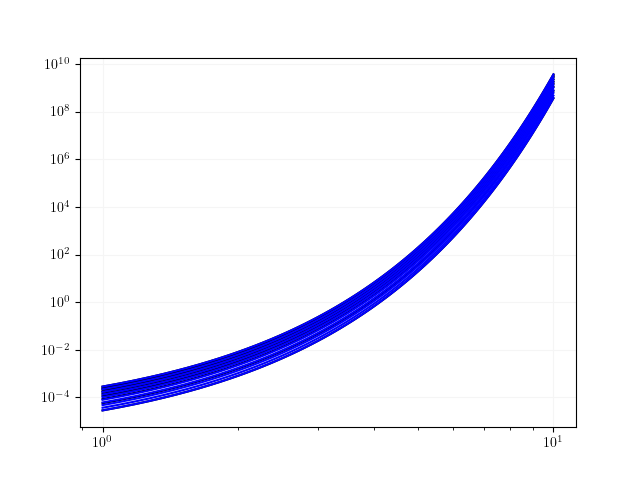

In [9]:
plt.ioff()
fig, ax = plt.subplots()
for f in f_lin.T:
    ax.loglog(ns, f, color="black")
for f in f_log.T:
    ax.loglog(ns, f, color="blue")
    
plt.show()

In [10]:
fig, ax = plt.subplots()

ax.semilogx(dx_lin, np.zeros_like(dx_lin), '.')
ax.semilogx(dx_log, np.zeros_like(dx_log), '.')
# ax.plot(dx_lin, lambda_s, '.')

fig.savefig("../../dx_lin_log.png")

: 